In [134]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import joblib
import os

In [135]:
# Load data
path    = "processed_data/combine.csv"
df      = pd.read_csv(path)
df.shape

(299754, 1320)

In [136]:
# Clean data
df.dropna(thresh=50000, axis=1, inplace=True)
df.drop(columns=['race'], inplace=True)
df = df.dropna(subset=['Weight (Lbs)'])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='most_frequent')
df      = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

X = df.drop(columns=["subject_id", "dod"])
y = df["dod"]
print(X.shape, y.shape)

(110818, 101) (110818,)


In [137]:
df.isnull().sum()

subject_id            0
isMale                0
anchor_age            0
anchor_year           0
dod                   0
                     ..
Problem List          0
ICU Admission date    0
Heart Rate            0
Rubidium              0
Samarium              0
Length: 103, dtype: int64

In [138]:
# Function to save ML models into '/models'
def save_model(model, model_name):
    try:
        if not os.path.exists("models"):
            os.makedirs("models")
        joblib.dump(model, f"models/{model_name}.pkl")
    except:
        pass

In [139]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create results array
results = []

# Models to run
models = {
    "randomforest":   RandomForestClassifier(n_estimators=10), 
    "xgboost":  XGBClassifier(), 
    "naivebayes":   GaussianNB(), 
    "logisticregression":   LogisticRegression()}

In [140]:
# Fit models and save
for name in models:
    model = models[name]
    model.fit(X_train, y_train)
    save_model(model, name)
    results.append((name, model))

Model: randomforest - Accuracy: 0.9163057209889911


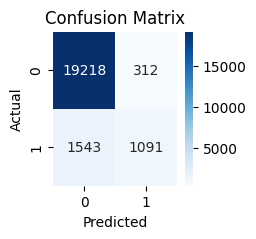

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95     19530
         1.0       0.78      0.41      0.54      2634

    accuracy                           0.92     22164
   macro avg       0.85      0.70      0.75     22164
weighted avg       0.91      0.92      0.90     22164



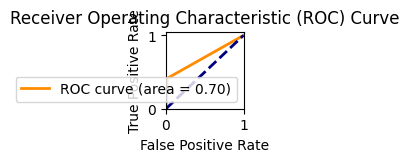

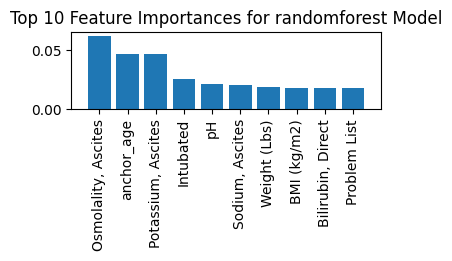

Model: xgboost - Accuracy: 0.9328189857426458


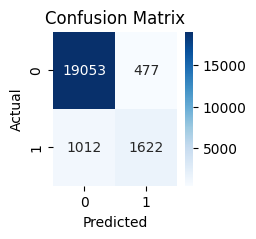

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     19530
         1.0       0.77      0.62      0.69      2634

    accuracy                           0.93     22164
   macro avg       0.86      0.80      0.82     22164
weighted avg       0.93      0.93      0.93     22164



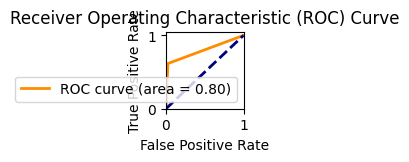

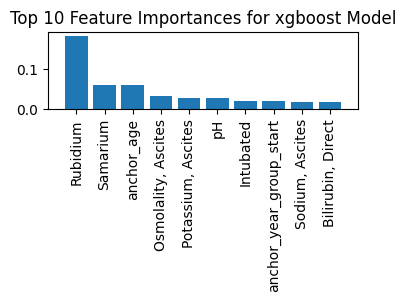

Model: naivebayes - Accuracy: 0.8813391084641762


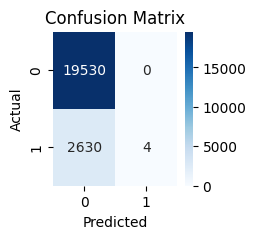

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     19530
         1.0       1.00      0.00      0.00      2634

    accuracy                           0.88     22164
   macro avg       0.94      0.50      0.47     22164
weighted avg       0.90      0.88      0.83     22164



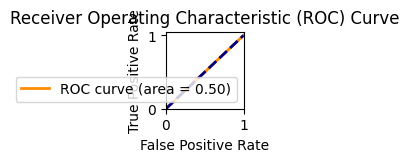

Model: logisticregression - Accuracy: 0.8807525717379534


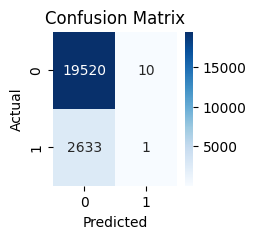

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     19530
         1.0       0.09      0.00      0.00      2634

    accuracy                           0.88     22164
   macro avg       0.49      0.50      0.47     22164
weighted avg       0.79      0.88      0.83     22164



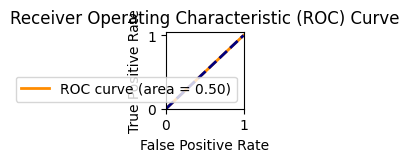

In [141]:
# Analysis
for name, model in results:
    # Test model
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {name} - Accuracy: {accuracy}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.gcf().set_size_inches(2, 2)
    plt.savefig(f'confusion_matrix_{name}.png')  # Save confusion matrix
    plt.show()

    # Classification report
    cr = classification_report(y_test, y_pred)
    print(f"Classification Report:\n{cr}")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.gcf().set_size_inches(1, 1)
    plt.savefig(f'roc_curve_{name}.png')  # Save ROC curve
    plt.show()

    # Feature importances
    if name == "randomforest" or name == "xgboost":
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        features = X.columns

        top_n = 10
        indices = indices[:top_n]
        importances = importances[indices]
        features = np.array(features)[indices]

        plt.figure()
        plt.title(f"Top 10 Feature Importances for {name} Model")
        plt.bar(range(len(indices)), importances, align="center")
        plt.xticks(range(len(indices)), features, rotation=90)
        plt.xlim([-1, len(indices)])
        plt.gcf().set_size_inches(4, 1)
        plt.savefig(f'top_features_{name}.png')  # Save top features plot
        plt.show()

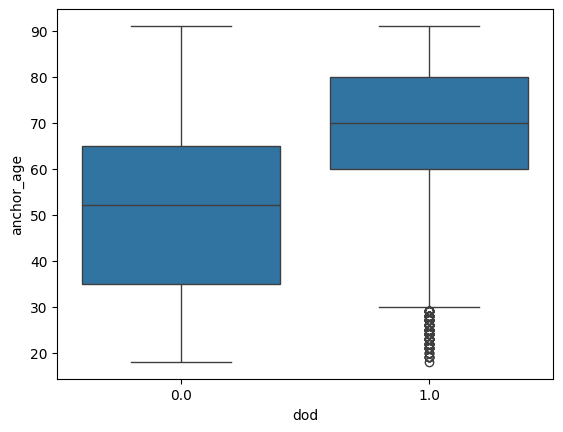

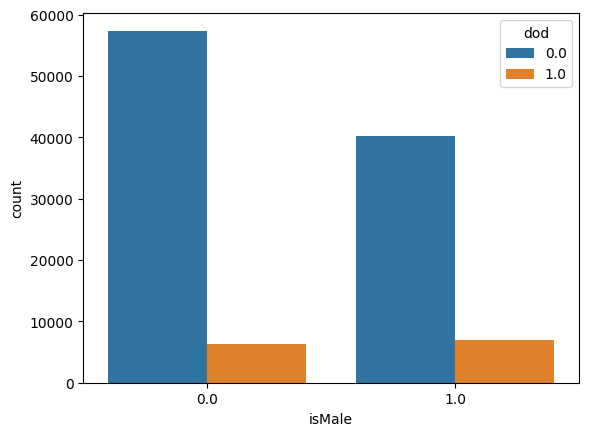

In [142]:
# Age and gender distributions
sns.boxplot(x='dod', y='anchor_age', data=df)
plt.show()

# Example: Gender distribution by mortality
sns.countplot(x='isMale', hue='dod', data=df)
plt.show()

In [143]:
# get percentage of people who died
died = df[df['dod'] == 1]
died.shape[0] / df.shape[0]

0.11964662780414734